In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import shutil

In [154]:
batch_size = 32
img_height = 180
img_width = 180

In [155]:
#Deleting hidden folder
directory = '/content/input'
shutil.rmtree(f"{directory}/.ipynb_checkpoints")

In [174]:
from random import randint

random_seed = randint(1, 100)

93


In [156]:
train_ds = tf.keras.utils.image_dataset_from_directory(
           directory,
           labels="inferred",
           validation_split=0.1,
           subset="training",
           batch_size=batch_size,
           image_size=(img_height, img_width),
           seed=random_seed,
           )

Found 346 files belonging to 2 classes.
Using 277 files for training.


In [157]:
val_ds = tf.keras.utils.image_dataset_from_directory(
         directory,
         labels='inferred',
         validation_split=0.1,
         subset="validation",
         seed=123,
         image_size=(img_height, img_width),
         batch_size=batch_size)

Found 346 files belonging to 2 classes.
Using 69 files for validation.


In [158]:
class_names = train_ds.class_names
print(class_names)

['beagle', 'chihuahua']


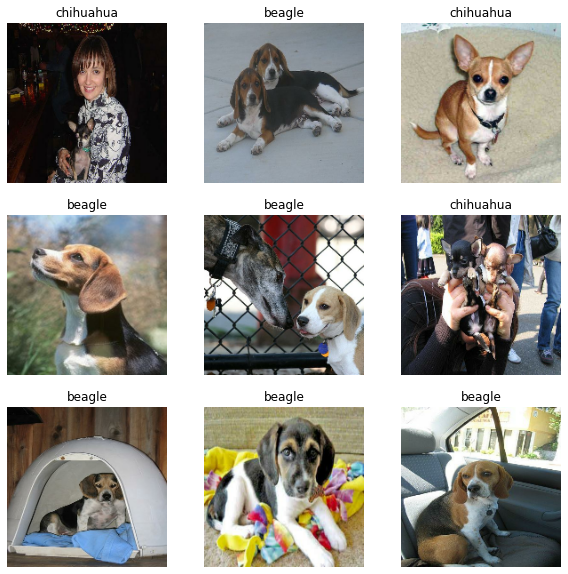

In [159]:
# Showing random photos
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [39]:
# Optimizing proccessing
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [40]:
# Standardizing RGB values
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [161]:
# Data enlargement
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

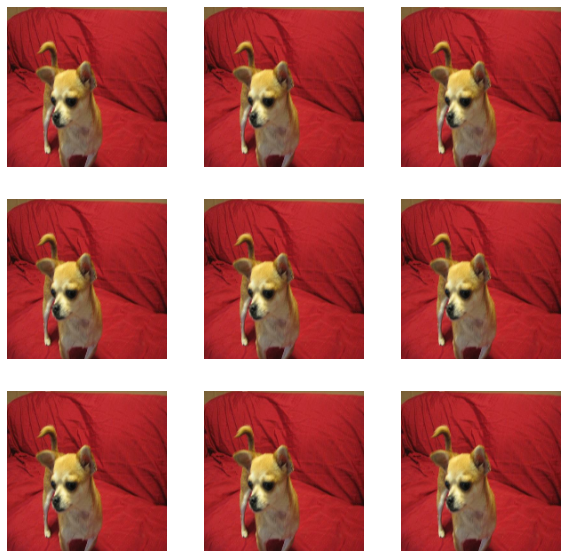

In [176]:
# Examples of added photos
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [163]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [164]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [166]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
9/9 [==============================] - 12s 1s/step - loss: 1.8163 - accuracy: 0.5596 - val_loss: 0.7199 - val_accuracy: 0.3768
Epoch 2/20
9/9 [==============================] - 10s 1s/step - loss: 0.6977 - accuracy: 0.4982 - val_loss: 0.6710 - val_accuracy: 0.6232
Epoch 3/20
9/9 [==============================] - 10s 1s/step - loss: 0.7077 - accuracy: 0.4549 - val_loss: 0.6987 - val_accuracy: 0.3768
Epoch 4/20
9/9 [==============================] - 10s 1s/step - loss: 0.6918 - accuracy: 0.5054 - val_loss: 0.6832 - val_accuracy: 0.6232
Epoch 5/20
9/9 [==============================] - 10s 1s/step - loss: 0.6888 - accuracy: 0.5487 - val_loss: 0.6663 - val_accuracy: 0.6232
Epoch 6/20
9/9 [==============================] - 10s 1s/step - loss: 0.6892 - accuracy: 0.5487 - val_loss: 0.6877 - val_accuracy: 0.6232
Epoch 7/20
9/9 [==============================] - 10s 1s/step - loss: 0.6865 - accuracy: 0.5487 - val_loss: 0.6738 - val_accuracy: 0.6232
Epoch 8/20
9/9 [==================

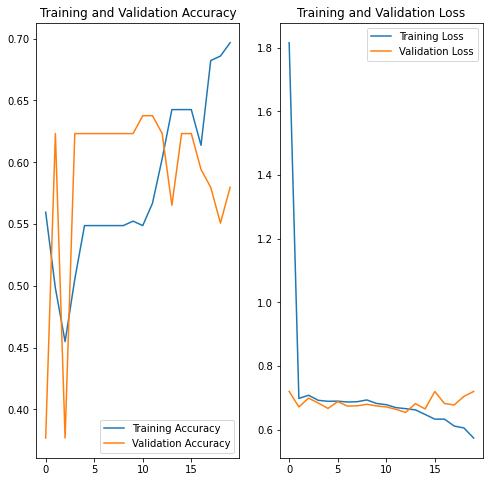

In [167]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [172]:
dog_url = "https://www.zooplus.pl/magazyn/wp-content/uploads/2017/12/beagle-rasa-psa.jpeg"
dog_path = tf.keras.utils.get_file('Dog_image', origin=dog_url)

img = tf.keras.utils.load_img(dog_path, target_size=(img_height, img_width))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(score)

print(
    f"This image most likely belongs to {class_names[np.argmax(score)]} with a {round(100 * np.max(score), 2)}% confidence."
)

1/1 [==============================] - 0s 28ms/step
tf.Tensor([0.5224975  0.47750255], shape=(2,), dtype=float32)
This image most likely belongs to beagle with a 52.25% confidence.
